In [1]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
multiplier = scipy.stats.norm.ppf(0.9) / (6 ** 0.5)

In [3]:
data = pd.read_csv('../results/results_summary.csv')

In [4]:
data_mean = pd.DataFrame(data.groupby(['Demand Level', 'Scenario', 'Resource Level', 'Traffic Level'])['Percent Abandoned', 'Ambulance Utilisation', 'RRV Utilisation', 'Mean Response Time'].mean()).reset_index()
data_sd = pd.DataFrame(data.groupby(['Demand Level', 'Scenario', 'Resource Level', 'Traffic Level'])['Percent Abandoned', 'Ambulance Utilisation', 'RRV Utilisation', 'Mean Response Time'].std()).reset_index()

In [5]:
def plot_scenario_year(scenario, year, confidence):
    multiplier = scipy.stats.norm.ppf(confidence) / (6 ** 0.5)
    demand_levels = [13, 19, 34, 45]
    colours = ['forestgreen', 'gold', 'darkorange', 'red']
    mean_datas = {
        d: data_mean[(data_mean['Demand Level'] == d) & (data_mean['Scenario'] == scenario) & (data_mean['Traffic Level'] == year)][['Resource Level', 'Percent Abandoned', 'Ambulance Utilisation', 'RRV Utilisation', 'Mean Response Time']].set_index('Resource Level')
        for d in demand_levels
    }
    sd_datas = {
        d: data_sd[(data_sd['Demand Level'] == 13) & (data_sd['Scenario'] == scenario) & (data_sd['Traffic Level'] == year)][['Resource Level', 'Percent Abandoned', 'Ambulance Utilisation', 'RRV Utilisation', 'Mean Response Time']].set_index('Resource Level')
        for d in demand_levels
    }
    
    ls = {}
    fig, axarr = plt.subplots(2, 2, figsize=(12, 8))
    for d, c in zip(demand_levels, colours):
        plot_ambulance_utilisations(ax=axarr[0, 0], demand_level=d, colour=c, mean_datas=mean_datas, sd_datas=sd_datas, multiplier=multiplier)
        plot_rrv_utilisations(ax=axarr[0, 1], demand_level=d, colour=c, mean_datas=mean_datas, sd_datas=sd_datas, multiplier=multiplier)
        plot_percent_abandoned(ax=axarr[1, 0], demand_level=d, colour=c, mean_datas=mean_datas, sd_datas=sd_datas, multiplier=multiplier)
        plot_mean_response_times(ax=axarr[1, 1], demand_level=d, colour=c, mean_datas=mean_datas, sd_datas=sd_datas, multiplier=multiplier)
        ls[d] = axarr[0, 1].plot([], [], c=c, label=f"Demand {d}%")
    axarr[0, 1].legend(fontsize=16, frameon=True)
    fig.suptitle(f'Scenario: {scenario}, Traffic Level: {year}', fontsize=24)
    plt.tight_layout()
    return fig

In [6]:
def plot_ambulance_utilisations(ax, demand_level, colour, mean_datas, sd_datas, multiplier):
    ax.fill_between(
        range(75, 100),
        (mean_datas[demand_level]['Ambulance Utilisation'] - (sd_datas[demand_level]['Ambulance Utilisation'] * multiplier)) * 100,
        (mean_datas[demand_level]['Ambulance Utilisation'] + (sd_datas[demand_level]['Ambulance Utilisation'] * multiplier)) * 100,
        alpha=0.3,
        color=colour
    )
    ax.plot(mean_datas[demand_level]['Ambulance Utilisation'] * 100, color=colour)
    ax.set_ylim(0, 100)
    ax.set_ylabel('Ambulance Utilisation (%)', fontsize=16)
    ax.set_xlabel('Resource Level', fontsize=16)
    ax.set_xlim(75, 99)

In [7]:
def plot_rrv_utilisations(ax, demand_level, colour, mean_datas, sd_datas, multiplier):
    ax.fill_between(
        range(75, 100),
        (mean_datas[demand_level]['RRV Utilisation'] - (sd_datas[demand_level]['RRV Utilisation'] * multiplier)) * 100,
        (mean_datas[demand_level]['RRV Utilisation'] + (sd_datas[demand_level]['RRV Utilisation'] * multiplier)) * 100,
        alpha=0.3,
        color=colour
    )
    ax.plot(mean_datas[demand_level]['RRV Utilisation'] * 100, color=colour)
    ax.set_ylim(0, 100)
    ax.set_ylabel('RRV Utilisation (%)', fontsize=16)
    ax.set_xlabel('Resource Level', fontsize=16)
    ax.set_xlim(75, 99)

In [8]:
def plot_percent_abandoned(ax, demand_level, colour, mean_datas, sd_datas, multiplier):
    ax.fill_between(
        range(75, 100),
        (mean_datas[demand_level]['Percent Abandoned'] - (sd_datas[demand_level]['Percent Abandoned'] * multiplier)) * 100,
        (mean_datas[demand_level]['Percent Abandoned'] + (sd_datas[demand_level]['Percent Abandoned'] * multiplier)) * 100,
        alpha=0.3,
        color=colour
    )
    ax.plot(mean_datas[demand_level]['Percent Abandoned'] * 100, color=colour)
    ax.set_ylabel('Percent Abandoned', fontsize=16)
    ax.set_xlabel('Resource Level', fontsize=16)
    ax.set_xlim(75, 99)

In [9]:
def plot_mean_response_times(ax, demand_level, colour, mean_datas, sd_datas, multiplier):
    ax.fill_between(
        range(75, 100),
        (mean_datas[demand_level]['Mean Response Time'] - (sd_datas[demand_level]['Mean Response Time'] * multiplier)) * (24 * 60),
        (mean_datas[demand_level]['Mean Response Time'] + (sd_datas[demand_level]['Mean Response Time'] * multiplier)) * (24 * 60),
        alpha=0.3,
        color=colour
    )
    ax.plot(mean_datas[demand_level]['Mean Response Time'] * (24 * 60), color=colour)
    ax.set_ylabel('Mean Response Time (mins)', fontsize=16)
    ax.set_xlabel('Resource Level', fontsize=16)
    ax.set_xlim(75, 99)

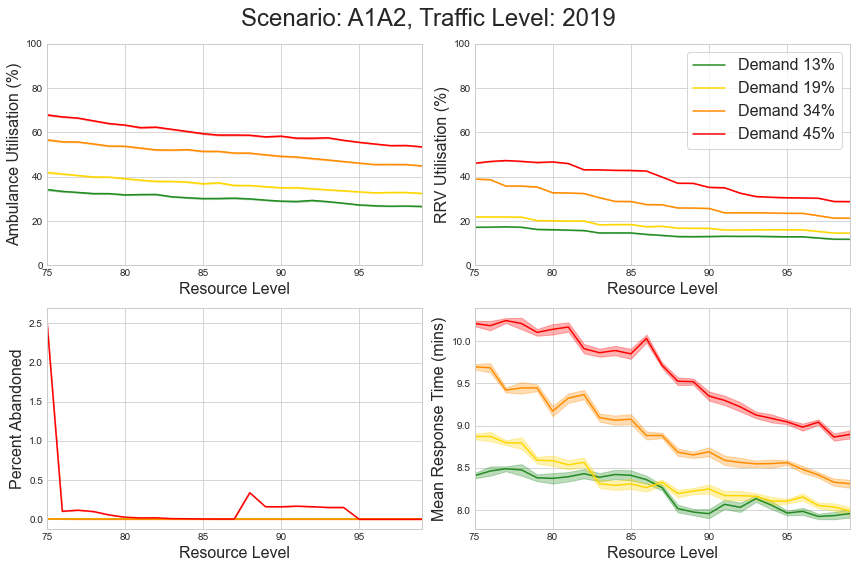

In [10]:
fig = plot_scenario_year('A1A2', 2019, 0.9);
fig.savefig('plot_A1A2_2019.pdf')

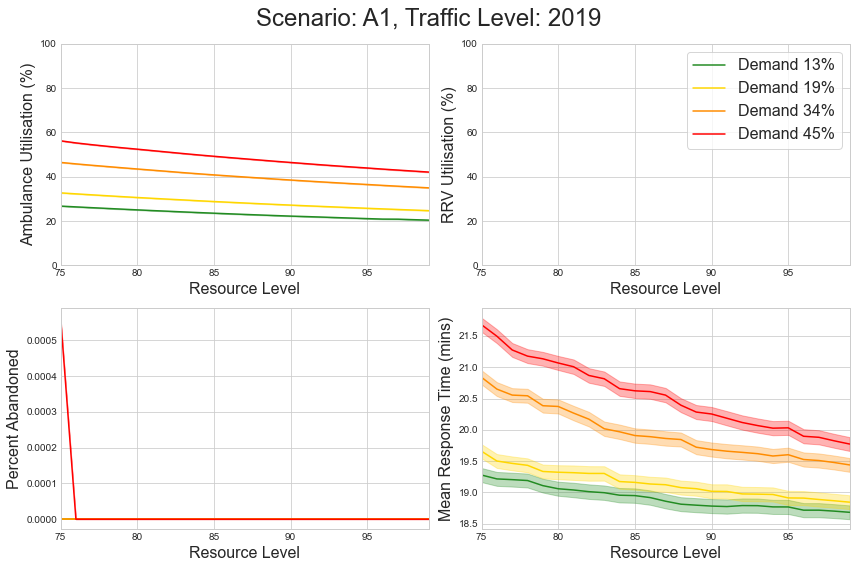

In [11]:
fig = plot_scenario_year('A1', 2019, 0.9)
fig.savefig('plot_A1_2019.pdf')